In [23]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/kirill/Projects/NIR')
import sequence_generator as generator
import numpy as np
import matplotlib.pylab as plt
from pomegranate import *
from utils import frequency_occurrence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


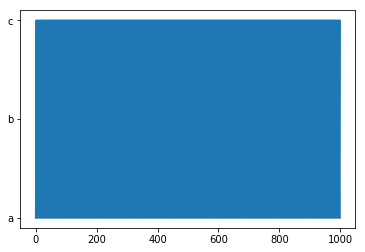

In [72]:
N = 1000
sequence = generator.Sequence(N,['a','b','c'],type='period')
seq = sequence.sequence
#seq = np.array(sequence.to_int()).reshape(-1,1)
#print(seq.shape)
plt.plot(seq)

['a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'b', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'a', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'a', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'a', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'b', 'b', 'c', 'b', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'a', 'a', 'b', 'c', 'a', 'b', 'a', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'c', 'b', 'c', 'b', 'b', 'c', 'b', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a', 'b',

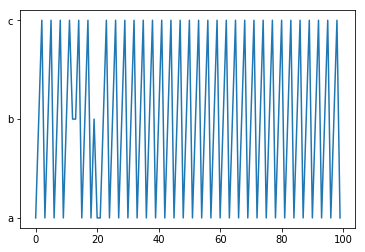

In [82]:
anormal = sequence.unormal(0.1)
plt.plot(anormal[:100])
print(anormal)

In [83]:
frequency_occurrence(anormal)

{'b': 0.355, 'a': 0.319, 'c': 0.326}


{'b': 0.355, 'a': 0.319, 'c': 0.326}

In [84]:
model = HiddenMarkovModel()
#print(model.dense_transition_matrix())
# model = model.from_samples(distribution = DiscreteDistribution, n_components = 3,X = [seq],max_iterations=2000,
#                           labels = [anormal], algorithm = 'labeled')
model = model.from_samples(distribution = DiscreteDistribution, n_components = 3,X = [seq],max_iterations=2000)
#model.fit(seq);
print(model)

None:{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "dtype" : "numpy.str_",
        "name" : "DiscreteDistribution",
        "parameters" : [
            {
                "a" : 3.810520895810555e-33,
                "b" : 1.0,
                "c" : 8.222063761971127e-51
            }
        ],
        "frozen" : false
    },
    "name" : "s0",
    "weight" : 1.0
}{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "dtype" : "numpy.str_",
        "name" : "DiscreteDistribution",
        "parameters" : [
            {
                "a" : 1.0,
                "b" : 2.803608146235914e-57,
                "c" : 2.5915311835940974e-52
            }
        ],
        "frozen" : false
    },
    "name" : "s1",
    "weight" : 1.0
}{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "dtype" : "numpy.str_",
        "name" : "DiscreteDistribution",
        "parameters" : [
  

In [85]:
model.dense_transition_matrix()

array([[2.32861782e-47, 6.59872630e-51, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 1.05863044e-52, 1.49361138e-53, 0.00000000e+00,
        0.00000000e+00],
       [3.81052090e-33, 1.00000000e+00, 1.14627836e-32, 0.00000000e+00,
        0.00000000e+00],
       [2.79105837e-54, 1.00000000e+00, 1.23533781e-50, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [86]:
model.dense_transition_matrix()

array([[2.32861782e-47, 6.59872630e-51, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 1.05863044e-52, 1.49361138e-53, 0.00000000e+00,
        0.00000000e+00],
       [3.81052090e-33, 1.00000000e+00, 1.14627836e-32, 0.00000000e+00,
        0.00000000e+00],
       [2.79105837e-54, 1.00000000e+00, 1.23533781e-50, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [87]:
print(model.log_probability(seq))
print(model.log_probability(anormal))

0.0
-6645.737935368601


/home/kirill/.conda/envs/nir/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Install pygraphviz for nicer visualizations
  """Entry point for launching an IPython kernel.


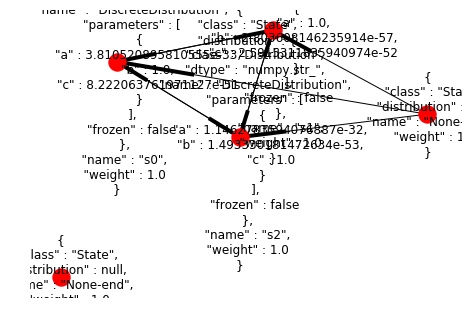

In [88]:
model.plot()

In [89]:
if 5>3 and 5<=5.1:
    print(1)

1


0
1
2
[[0.   0.01]
 [0.01 0.2 ]
 [0.2  1.  ]]
1500


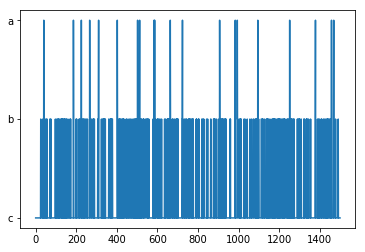

In [90]:
d1 = DiscreteDistribution({'a': 0.10, 'c': 0.40, 'g': 0.40, 't': 0.10})

d1 = DiscreteDistribution({'a':0, 'c': 0.40,})

d2 = ConditionalProbabilityTable([['a', 'a', 0.10]], [d1])
s1 = generator.Sequence(1500,['a','b','c'],type = 'random',p=[0.01,0.2]).sequence
plt.plot(s1)
print(len(s1))

In [47]:
a = np.array(s1)
a.shape

(1500,)

In [48]:
train = []
for i in map( list, ('aabbcc', 'a', 'abcaaabcaacccaca', 'abcaaaabbaccc') ):
    train+=[i]
train
print(np.array(train[0]))

['a' 'a' 'b' 'b' 'c' 'c']


In [28]:
model.fit( map( list, ('aabbcc', 'a', 'abcaaabcaacccaca', 'abcaaaabbaccc') ) )

ValueError: Symbol 'a' is not defined in a distribution

In [29]:
model_chain = MarkovChain([d1,d2,d1,d2,d1,d2]).from_samples(X = s1)
print(model_chain)
model_chain.fit(s1)
print(model_chain)
print(len(model_chain.distributions))

2


In [30]:
model_chain.distributions

[{
     "class" :"Distribution",
     "dtype" :"str",
     "name" :"DiscreteDistribution",
     "parameters" :[
         {
             "a" :0.011333333333333334,
             "b" :0.18533333333333332,
             "c" :0.8033333333333333
         }
     ],
     "frozen" :false
 }, {
     "class" : "Distribution",
     "name" : "ConditionalProbabilityTable",
     "table" : [
         [
             "a",
             "a",
             "0.3333333333333333"
         ],
         [
             "a",
             "b",
             "0.3333333333333333"
         ],
         [
             "a",
             "c",
             "0.3333333333333333"
         ],
         [
             "b",
             "a",
             "0.3333333333333333"
         ],
         [
             "b",
             "b",
             "0.3333333333333333"
         ],
         [
             "b",
             "c",
             "0.3333333333333333"
         ],
         [
             "c",
             "a",
             "0.3

In [31]:
model.log_probability(s1)

ValueError: Symbol 'c' is not defined in a distribution

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel.log_probability'
Traceback (most recent call last):
  File "pomegranate/hmm.pyx", line 100, in pomegranate.hmm._check_input
ValueError: Symbol 'c' is not defined in a distribution


0.0

In [32]:
d1 = UniformDistribution(1,5)

In [33]:
b = d1.sample(100)
b

array([3.90101712, 3.00529753, 4.82433454, 3.5759608 , 2.69542019,
       3.42557286, 1.07677279, 2.20629927, 3.64069415, 2.16031043,
       3.47206172, 2.7150748 , 1.54189626, 2.1931293 , 3.27985964,
       3.36349104, 3.297301  , 3.61280328, 3.60841308, 2.72567374,
       4.58618638, 2.47024748, 2.7434597 , 4.56769342, 4.22477596,
       3.81555433, 1.40090755, 4.67793045, 3.8569652 , 4.99538803,
       1.59779322, 4.47250423, 1.64997174, 3.46223826, 1.49527993,
       4.39203292, 4.22927583, 3.27640295, 2.62873319, 1.27666798,
       3.78971509, 2.81417073, 3.8882224 , 4.4655293 , 4.90208602,
       4.42321337, 1.04685634, 2.43991226, 3.91996225, 1.68651871,
       3.08414642, 1.21735195, 1.7999861 , 1.07408718, 4.17479081,
       1.89569875, 2.38140672, 4.71232517, 3.81765761, 1.12735572,
       1.65877663, 3.48591361, 3.30891435, 1.95157129, 4.73685599,
       3.45586382, 3.14253121, 3.35963991, 3.92048812, 2.24777998,
       2.59288425, 1.839375  , 1.74477202, 4.77748956, 3.95820